In [1]:
import sys

from LIM_lightcone import paint_lightcone,make_survey,make_measurements
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as cu
from scipy.interpolate import interp2d,interp1d
from scipy.optimize import curve_fit

from lim import lim

from nbodykit.algorithms import FFTPower

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as clrs
import matplotlib.cm as cmap
import matplotlib.patches as patches
from matplotlib.patches import Rectangle as rect
from matplotlib.collections import PatchCollection

colors = ['#8a1f1f','#79a43a','#C59D34','#171782', '#cf6717','#ad6faa',
          '#009999','#828282']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 2.

%matplotlib inline

In [2]:
def linear_color(col1,col2):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [col1,col2])
    return cmap

#############################################

def SFR_Mz_2dinterp(M,z,SFR_file):
    '''
    Returns SFR(M,z) interpolated from tables of 1+z, log10(Mhalo/Msun) and 
    log10(SFR / (Msun/yr)), in three columns, where 1+z is the innermost index 
    (the one running fast compared with the mass)
    '''
    #SFR_folder = os.path.dirname(os.path.realpath(__file__)).split("source")[0]+'SFR_tables/'
    #try:
    #    x = np.loadtxt(SFR_folder+SFR_file)
    #except:
    x = np.loadtxt(SFR_file)
    zb = np.unique(x[:,0])-1.
    logMb = np.unique(x[:,1])
    logSFRb = x[:,2].reshape(len(zb),len(logMb),order='F')
    
    logSFR_interp = interp2d(logMb,zb,logSFRb,bounds_error=False,fill_value=-40.)
    
    if 'sfr_table_Behroozi' in SFR_file:
        M *= 0.678
        
    try:
        logM = np.log10((M).value)
    except:
        logM = np.log10(M)
    if np.array(z).size>1:
        SFR = np.zeros(logM.size)
        for ii in range(0,logM.size):
            SFR[ii] = 10.**logSFR_interp(logM[ii],z[ii])
    else:
        SFR = 10.**logSFR_interp(logM,z)
    
    return SFR

# Setting parameters

In [9]:
def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)

def lim_params(SFR_file, Tsys,z,Dz,sigma_scatter=0.3,sig_SFR=0.6,
              Nfeeds = 1000, beam = 4, tobs = 1000,
              Omega_field = 100,dnu=10):
    #Setting line model and observational parameters. Default with RSD, smooth, one_halo, at z=2.5.
    cosmo_fid = dict(cosmo_input_camb={'H0':67.8,'ombh2':0.02312,'omch2':0.118002988,
                      'As':2.23832e-9,'ns':0.96,'mnu':0.06, 'f_NL':0})
    h=cosmo_fid['cosmo_input_camb']['H0']/100
        
    nu=115.271*u.GHz
    nuObs, Dnu = Dnu_from_Dz(nu, z, Dz)
    model_params = dict(nu=nu, nuObs=nuObs, 
                        sigma_scatter=sigma_scatter,
                        hmf_model='Tinker', 
                        bias_model='Tinker10', 
                        model_type='ML',
                        Mmin = 1e10/h*u.Msun, Mmax=1e15/h*u.Msun,
                        model_par={'alpha':1.37, 'beta':-1.74, 'dMF':1.0,'SFR_file':SFR_file,'sig_SFR':sig_SFR},
                        model_name='TonyLi', 
                        do_onehalo=True, do_RSD=True, smooth=False, 
                        kmin=1e-5*u.Mpc**-1, kmax=1e3*u.Mpc**-1, 
                        nk=512, nmu=10000, 
                        nT=2**21, Tmin_VID = 1.0e-4*u.uK)
    obs_params = dict(Delta_nu=Dnu, dnu=dnu*u.MHz, 
                      Tsys_NEFD=Tsys*u.K, 
                      Nfeeds=Nfeeds, 
                      beam_FWHM=beam*u.arcmin, 
                      tobs=tobs*u.hr,
                      Omega_field=Omega_field*u.deg**2, 
                      Nfield=1)
                
    obs_params.update(model_params)
    obs_params.update(cosmo_fid)
    return obs_params

def LC_params(do_exSFR, exSFR, exSFR_pars, Tsys,
              zmin_obs, zmax_obs,zmin=2.2,zmax=3.5,
              sigma_scatter=0.3,sig_SFR=0.6,
              Nfeeds = 1000, beam = 4, tobs = 1000,
              dnu=10,
              RAObs_edge = 4.5, DECObs_edge = 4.5,smooth=False):
    nu_CO=115.271*u.GHz

    model_params=dict(halo_lightcone_dir='/home/jlbernal/LightCone_S82_UM/', 
                      lines=dict(CO=True),
                      models=dict(CO=dict(model_name='CO_Li16',
                                          model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':sigma_scatter})),
                      do_external_SFR = do_exSFR, external_SFR = exSFR,
                      SFR_pars=exSFR_pars,
                      supersample=3,
                      Nmu=10,
                      dk=0.01*u.Mpc**-1)
    obs_params=dict(zmin = zmin, zmax = zmax,
                    RAObs_min=-RAObs_edge*u.deg,RAObs_max=RAObs_edge*u.deg,
                    DECObs_min=-DECObs_edge*u.deg,DECObs_max=DECObs_edge*u.deg,
                    RA_min=-5.0*u.deg,RA_max=5.0*u.deg,
                    DEC_min=-5.0*u.deg,DEC_max=5.0*u.deg,
                    nuObs_max=nu_CO/(1+zmin_obs), nuObs_min=nu_CO/(1+zmax_obs),
                    beam_FWHM=beam*u.arcmin, 
                    dnu=dnu*u.MHz,
                    Tsys=Tsys*u.K, 
                    Nfeeds=Nfeeds, 
                    tobs=tobs*u.hr,
                    linear_VID_bin=True, Tmin_VID = -100*u.uK,Nbin_hist=100,Tmax_VID=10000*u.uK,
                    do_smooth=False,remove_noise=True)
    obs_params.update(model_params)
    return obs_params

# Call lim and LC

We call lim for theoretical comparison, and 3 instance of LC to compare the SFR from UM (its own scatter, SFR running with z), parametric SFR representing UM, and parametric SFR representing BWC13 

#### Custom SFRs

\begin{equation}
\text{SFR}(M) = M_0 \left(\frac{M}{M_a}\right)^a\left[1+ \left(\frac{M}{M_b}\right)^b\right]^c
\end{equation}



In [4]:
def func(M,Ma,Mb,a,b,c):
    M0 = -6
    return np.log10(10**M0*((M/10**Ma)**a)*(1+(M/10**Mb)**b)**c)


In [5]:
z = 2.8
logM=np.log10(np.logspace(10, 14, 100))
sfr_um = SFR_Mz_2dinterp(10**logM,z,'../SFR_tables/sfr_table_normalmean_UniverseMachine_medianFalse_clean_solMass.dat')
sfr_bwc = SFR_Mz_2dinterp(10**logM,z,'../SFR_tables/sfr_table_Behroozi.dat')          
popt_um, pcov = curve_fit(func, 10**logM[np.logical_and(np.log10(sfr_um)>-3 , logM>10.5)], np.log10(sfr_um)[np.logical_and(np.log10(sfr_um)>-3, logM>10.5)],
                         p0=[8,12.3,1.9,3,-1.4])
popt_bwc, pcov = curve_fit(func, 10**logM[np.log10(sfr_bwc)>-3], np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3],
                          p0=[8,12.3,1.9,3,-0.7])

print('Universe Machine SFR at z = ',z)
print('-------------------------------')
print('M0 = {:.2f}, Ma = {:.2f}, Mb = {:.2f}'.format(-6,popt_um[0],popt_um[1]))
print('a = {:.2f}, b = {:.2f}, c = {:.2f}'.format(popt_um[2],popt_um[3],popt_um[4]))
print('')
print('BWC13 SFR at z = ',z)
print('-------------------------------')
print('M0 = {:.2f}, Ma = {:.2f}, Mb = {:.2f}'.format(-6,popt_bwc[0],popt_bwc[1]))
print('a = {:.2f}, b = {:.2f}, c = {:.2f}'.format(popt_bwc[2],popt_bwc[3],popt_bwc[4]))
print('')



Universe Machine SFR at z =  2.8
-------------------------------
M0 = -6.00, Ma = 8.09, Mb = 12.46
a = 1.87, b = 4.65, c = -0.89

BWC13 SFR at z =  2.8
-------------------------------
M0 = -6.00, Ma = 8.20, Mb = 12.32
a = 1.96, b = 6.53, c = -0.32



<ipython-input-5-dfede18182c9>:7: RuntimeWarning: divide by zero encountered in log10
  popt_bwc, pcov = curve_fit(func, 10**logM[np.log10(sfr_bwc)>-3], np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3],


<ipython-input-6-f10ca47e36f2>:11: RuntimeWarning: divide by zero encountered in log10
  ax.plot(logM[np.log10(sfr_bwc)>-3],np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3],c=colors[2],label='BWC13')


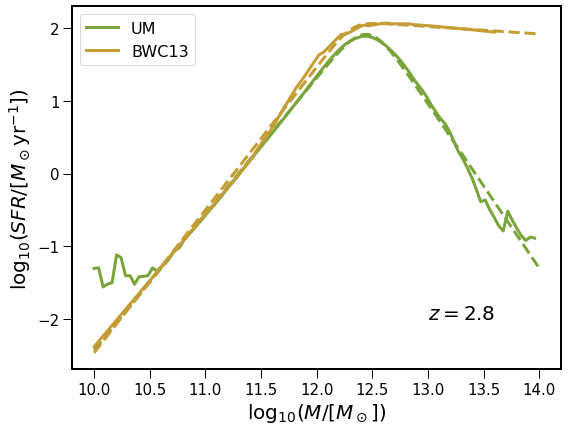

In [6]:
gs = gridspec.GridSpec(1, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0)
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

ax.plot(logM[np.log10(sfr_um)>-3],np.log10(sfr_um)[np.log10(sfr_um)>-3],c=colors[1],label='UM')
ax.plot(logM,func(10**logM,popt_um[0],popt_um[1],popt_um[2],
                            popt_um[3],popt_um[4]),c=colors[1],ls='--')


ax.plot(logM[np.log10(sfr_bwc)>-3],np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3],c=colors[2],label='BWC13')
ax.plot(logM,func(10**logM,popt_bwc[0],popt_bwc[1],popt_bwc[2],
                            popt_bwc[3],popt_bwc[4]),c=colors[2],ls='--')

ax.text(13,-2,r'$z = {}$'.format(z),fontsize=20)
ax.set_ylabel(r'$\log_{10} (SFR/ [M_\odot{\rm yr}^{-1}])$',fontsize=20)
ax.set_xlabel(r'$\log_{10} (M/ [M_\odot])$',fontsize=20)
ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)
ax.legend(fontsize=16)
plt.show()

#### No noise or smoothing at first

In [7]:
Tsys = 0.
z = 2.8
Dz = 0.4
sigma_scatter=0.3
sig_SFR=0.6

M = lim(lim_params('../SFR_tables/sfr_table_normalmean_UniverseMachine_medianFalse_clean_solMass.dat',
                   Tsys,z,Dz,sigma_scatter=sigma_scatter,sig_SFR = sig_SFR,Omega_field=81))



In [8]:
Tsys = 0.
zmin_obs, zmax_obs = 2.6,3.0
sigma_scatter=0.3
sig_SFR=0.5

model_um = dict(M0=1e-6, Ma=10**popt_um[0], Mb=10**popt_um[1], a=popt_um[2], b=popt_um[3], c=popt_um[4])
CO_UM = make_measurements(LC_params(True, 'Custom_SFR', model_um, Tsys,zmin_obs,zmax_obs))

model_bwc =dict(M0=1e-6, Ma=10**popt_bwc[0], Mb=10**popt_bwc[1], a=popt_bwc[2], b=popt_bwc[3], c=popt_bwc[4])
CO_BWC = make_measurements(LC_params(True, 'Custom_SFR', model_bwc, Tsys,zmin_obs,zmax_obs))

CO = make_measurements(LC_params(False, '', model_bwc, Tsys,zmin_obs,zmax_obs))


/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_152.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_153.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_154.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_155.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_156.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_157.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_158.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_159.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_160.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_161.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_162.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_163.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_164.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_165.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_166.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_167.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_168.fi

/home/jlbernal/preLIMinary/source/line_models.py:34: RuntimeWarning: divide by zero encountered in log10
  log10_LCO = (np.log10(LIR) - beta)/alpha


## Halo mass function

In [9]:
#halos within footprint
inds_RA = (CO_UM.halo_catalog['RA'] > CO_UM.RAObs_min.value)&(CO_UM.halo_catalog['RA'] < CO_UM.RAObs_max.value)
inds_DEC = (CO_UM.halo_catalog['DEC'] > CO_UM.DECObs_min.value)&(CO_UM.halo_catalog['DEC'] < CO_UM.DECObs_max.value)
inds_sky = inds_RA&inds_DEC

inds = (CO_UM.nuObs_line_halo['CO'] >= CO_UM.nuObs_min)&(CO_UM.nuObs_line_halo['CO'] <= CO_UM.nuObs_max)&inds_sky
M_in_survey = CO_UM.halo_catalog['M_HALO'][inds]*CO_UM.Msunh.to(CO_UM.Msunh).value

logMcat=np.log10(M_in_survey)
logM=np.linspace(np.min(logMcat), np.max(logMcat), 50)
Nhalos, _=np.histogram(logMcat, bins=logM)
dndM=Nhalos/np.diff(logM)[0]/((CO_UM.Lbox[0]*CO_UM.Lbox[1]*CO_UM.Lbox[2]).to(CO_UM.Mpch**3))



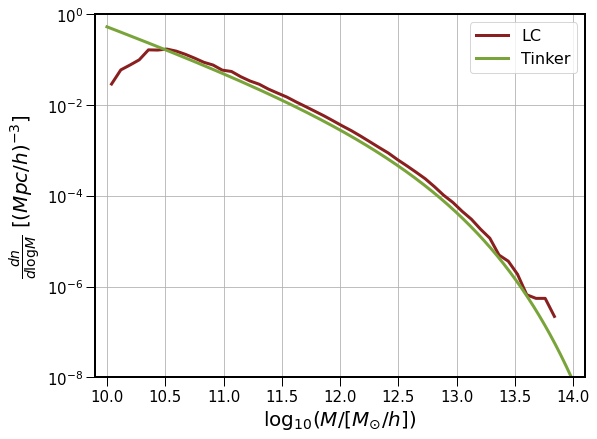

In [10]:
gs = gridspec.GridSpec(1, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0)
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

ax.semilogy(logM[:-1]+np.diff(logM)[0]/2, dndM, label='LC')
ax.semilogy(np.log10(M.M.to(M.Msunh).value), 
            np.log(10)*M.M.to(M.Msunh).value*M.dndM.to(M.Msunh**-1*M.Mpch**-3), label='Tinker')
ax.set_ylim(1e-8,1)
ax.set_xlim(9.9, 14.1)
ax.set_xlabel(r'$\log_{10}(M /[M_{\odot}/h])$',fontsize=20)
ax.set_ylabel(r'$\frac{dn}{d\log M}$ [$(Mpc/h)^{-3}]$',fontsize=20)
ax.legend(fontsize=16)
ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)
ax.grid()
plt.show()


In [32]:
inds_RA = (CO.halo_catalog['RA'] > CO.RAObs_min.value)&(CO.halo_catalog['RA'] < CO.RAObs_max.value)
inds_DEC = (CO.halo_catalog['DEC'] > CO.DECObs_min.value)&(CO.halo_catalog['DEC'] < CO.DECObs_max.value)
inds_sky = inds_RA&inds_DEC

inds = (CO.nuObs_line_halo['CO'] >= CO.nuObs_min)&(CO.nuObs_line_halo['CO'] <= CO.nuObs_max)&inds_sky
M_in_survey = CO.halo_catalog['M_HALO'][inds]*CO.Msunh.to(CO.Msunh).value

logMcat=np.log10(M_in_survey)
SFRcat=CO.halo_catalog['SFR_HALO'][inds]
LCO = CO.halos_in_survey['CO']['Lhalo'].value
logM=np.linspace(np.min(logMcat), np.max(logMcat), 50)

logM=np.linspace(np.min(logMcat), np.max(logMcat), 50)
sigSFR=[]
meanSFR=[]
meanLCO=[]
Nhalos=[]
for i in range(len(logM)-1):
    inds = (logMcat>=logM[i])&(logMcat<logM[i+1])&(SFRcat>0)
    logSFRbin=np.log10(SFRcat[inds])
    sigSFR.append(np.std(logSFRbin))
    meanSFR.append(np.mean(logSFRbin))
    Nhalos.append(len(logSFRbin))
    Lbin = LCO[inds]
    meanLCO.append(np.mean(Lbin)) 
    
sigSFR=np.asarray(sigSFR)
meanSFR=np.asarray(meanSFR)
meanLCO = np.asarray(meanLCO)
Nhalos=np.asarray(Nhalos)

In [33]:
weightedSFR=np.average(sigSFR[Nhalos>0], weights=Nhalos[Nhalos>0])
weightedSFR_by_LCO=np.average(sigSFR[Nhalos>0], weights=Nhalos[Nhalos>0]*meanLCO[Nhalos>0])

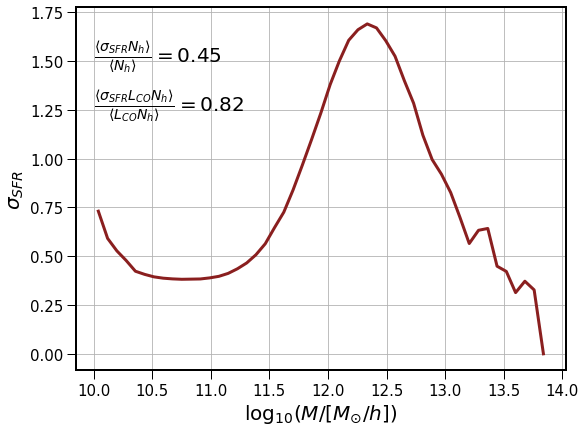

In [34]:
gs = gridspec.GridSpec(1, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0)
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

ax.plot(logM[:-1]+np.diff(logM)[0]/2, sigSFR)
ax.set_ylabel('$\sigma_{SFR}$',fontsize=20)
ax.set_xlabel(r'$\log_{10}(M /[M_{\odot}/h])$',fontsize=20)
ax.grid()

ax.text(10,1.5,r'$\frac{\langle \sigma_{SFR} N_h\rangle}{\langle N_h\rangle}  = $'+str(np.round(weightedSFR,2)),fontsize=20)
ax.text(10,1.25,r'$\frac{\langle \sigma_{SFR} L_{CO}N_h\rangle}{\langle L_{CO}N_h\rangle}  = $'+str(np.round(weightedSFR_by_LCO,2)),fontsize=20)

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)
plt.show()

In [55]:
inds_RA = (CO.halo_catalog['RA'] > CO.RAObs_min.value)&(CO.halo_catalog['RA'] < CO.RAObs_max.value)
inds_DEC = (CO.halo_catalog['DEC'] > CO.DECObs_min.value)&(CO.halo_catalog['DEC'] < CO.DECObs_max.value)
inds_sky = inds_RA&inds_DEC

inds = (CO.nuObs_line_halo['CO'] >= CO.nuObs_min)&(CO.nuObs_line_halo['CO'] <= CO.nuObs_max)&inds_sky
M_in_survey = CO.halo_catalog['M_HALO'][inds]*CO.Msunh.to(CO.Msunh).value

logMcat=np.log10(M_in_survey)
LCO = CO.halos_in_survey['CO']['Lhalo'].value
logM=np.linspace(np.min(logMcat), np.max(logMcat), 50)


inds_RA = (CO_UM.halo_catalog['RA'] > CO_UM.RAObs_min.value)&(CO_UM.halo_catalog['RA'] < CO_UM.RAObs_max.value)
inds_DEC = (CO_UM.halo_catalog['DEC'] > CO_UM.DECObs_min.value)&(CO_UM.halo_catalog['DEC'] < CO_UM.DECObs_max.value)
inds_sky = inds_RA&inds_DEC

inds = (CO_UM.nuObs_line_halo['CO'] >= CO_UM.nuObs_min)&(CO_UM.nuObs_line_halo['CO'] <= CO_UM.nuObs_max)&inds_sky
M_in_survey_UM = CO_UM.halo_catalog['M_HALO'][inds]*CO_UM.Msunh.to(CO_UM.Msunh).value

logMcat_UM=np.log10(M_in_survey_UM)
LCO_UM = CO_UM.halos_in_survey['CO']['Lhalo'].value
logM_UM=np.linspace(np.min(logMcat_UM), np.max(logMcat_UM), 50)



inds_RA = (CO_BWC.halo_catalog['RA'] > CO_BWC.RAObs_min.value)&(CO_BWC.halo_catalog['RA'] < CO_BWC.RAObs_max.value)
inds_DEC = (CO_BWC.halo_catalog['DEC'] > CO_BWC.DECObs_min.value)&(CO_BWC.halo_catalog['DEC'] < CO_BWC.DECObs_max.value)
inds_sky = inds_RA&inds_DEC

inds = (CO_BWC.nuObs_line_halo['CO'] >= CO_BWC.nuObs_min)&(CO_BWC.nuObs_line_halo['CO'] <= CO_BWC.nuObs_max)&inds_sky
M_in_survey_BWC = CO_BWC.halo_catalog['M_HALO'][inds]*CO_BWC.Msunh.to(CO_BWC.Msunh).value

logMcat_BWC=np.log10(M_in_survey_BWC)
LCO_BWC = CO_BWC.halos_in_survey['CO']['Lhalo'].value
logM_BWC=np.linspace(np.min(logMcat_BWC), np.max(logMcat_BWC), 50)

In [42]:
meanLCO=[]
meanLCO_UM=[]
meanLCO_BWC=[]

meanLCO=[]
meanLCO_UM=[]
meanLCO_BWC=[]

for i in range(len(logM)-1):
    inds = (logMcat>=logM[i])&(logMcat<logM[i+1])&(LCO>0)
    Lbin = LCO[inds]
    meanLCO.append(np.mean(Lbin)) 
    
    inds_UM = (logMcat_UM>=logM_UM[i])&(logMcat_UM<logM_UM[i+1])&(LCO_UM>0)
    Lbin_UM = LCO_UM[inds_UM]
    meanLCO_UM.append(np.mean(Lbin_UM)) 

    inds_BWC = (logMcat_BWC>=logM_BWC[i])&(logMcat_BWC<logM_BWC[i+1])&(LCO_BWC>0)
    Lbin_BWC = LCO_BWC[inds_BWC]
    meanLCO_BWC.append(np.mean(Lbin_BWC)) 
    

meanLCO = np.asarray(meanLCO)
meanLCO_UM = np.asarray(meanLCO_UM)
meanLCO_BWC = np.asarray(meanLCO_BWC)


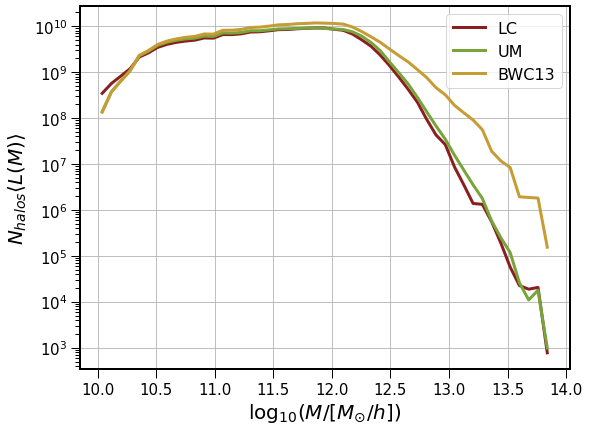

In [66]:
gs = gridspec.GridSpec(1, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0)
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

ax.semilogy(logM[:-1]+np.diff(logM)[0]/2, meanLCO*Nhalos,label='LC')
ax.semilogy(logM_UM[:-1]+np.diff(logM_UM)[0]/2, meanLCO_UM*Nhalos,label='UM')
ax.semilogy(logM_BWC[:-1]+np.diff(logM_BWC)[0]/2, meanLCO_BWC*Nhalos,label='BWC13')

ax.set_ylabel(r'$N_{halos}\langle L(M)\rangle $',fontsize=20)
ax.set_xlabel(r'$\log_{10}(M /[M_{\odot}/h])$',fontsize=20)
ax.grid()

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)

ax.legend(fontsize=16)

plt.show()

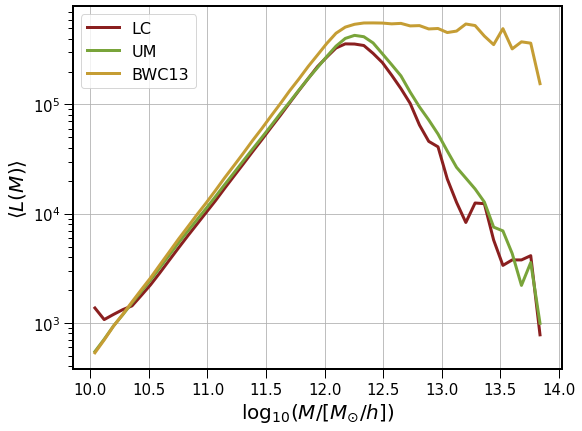

In [67]:
gs = gridspec.GridSpec(1, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0)
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

ax.semilogy(logM[:-1]+np.diff(logM)[0]/2, meanLCO,label='LC')
ax.semilogy(logM_UM[:-1]+np.diff(logM_UM)[0]/2, meanLCO_UM,label='UM')
ax.semilogy(logM_BWC[:-1]+np.diff(logM_BWC)[0]/2, meanLCO_BWC,label='BWC13')

ax.set_ylabel(r'$\langle L(M)\rangle $',fontsize=20)
ax.set_xlabel(r'$\log_{10}(M /[M_{\odot}/h])$',fontsize=20)
ax.grid()

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)

ax.legend(fontsize=16)

plt.show()

### No noise or smoothing at first

In [10]:
CO.Pk_2d
CO_UM.Pk_2d
CO_BWC.Pk_2d

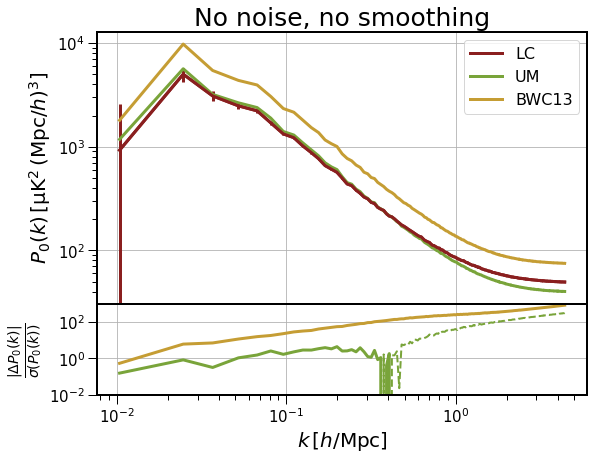

In [73]:
gs = gridspec.GridSpec(2, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0,height_ratios=[3,1])
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

ax.loglog(CO.k_Pk_poles, CO.Pk_0, label='LC')
ax.errorbar(CO.k_Pk_poles.value, CO.Pk_0.value,np.sqrt(CO.covmat_00.value),color=colors[0],alpha=1)
ax.loglog(CO_UM.k_Pk_poles, CO_UM.Pk_0, label='UM')
ax.loglog(CO_BWC.k_Pk_poles, CO_BWC.Pk_0, label='BWC13')

ax.set_ylabel(r'$P_0(k) \,[{\rm \mu K^2\, (Mpc/}h)^3] $',fontsize=20)
ax.set_xlabel(r'$k\,  [h/{\rm Mpc}]$',fontsize=20)
ax.grid()

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)

ax.legend(fontsize=16)
ax.set_title('No noise, no smoothing',fontsize=25)

ax = plt.subplot(gs[1,0])

ax.loglog(CO.k_Pk_poles, (CO.Pk_0-CO.Pk_0)/np.sqrt(CO.covmat_00), label='LC')
ax.loglog(CO_UM.k_Pk_poles, (CO_UM.Pk_0-CO.Pk_0)/np.sqrt(CO.covmat_00), label='UM')
ax.loglog(CO_BWC.k_Pk_poles, (CO_BWC.Pk_0-CO.Pk_0)/np.sqrt(CO.covmat_00), label='BWC13')

ax.loglog(CO_UM.k_Pk_poles, -(CO_UM.Pk_0-CO.Pk_0)/np.sqrt(CO.covmat_00), label='UM',ls='--',color=colors[1],lw=2)
ax.loglog(CO_BWC.k_Pk_poles, -(CO_BWC.Pk_0-CO.Pk_0)/np.sqrt(CO.covmat_00), label='BWC13',ls='--',color=colors[2],lw=2)

ax.set_ylabel(r'$\frac{\vert\Delta P_0(k)\vert}{\sigma(P_0(k))}$',fontsize=20)
ax.set_xlabel(r'$k\,  [h/{\rm Mpc}]$',fontsize=20)

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)

ax.set_ylim(1e-2,1000)
ax.grid()

plt.show()

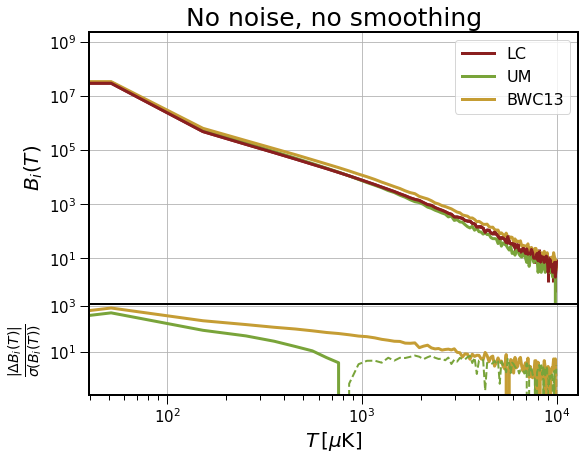

In [82]:
gs = gridspec.GridSpec(2, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0,height_ratios=[3,1])
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

ax.loglog(CO.Ti, CO.Bi_VID,label='LC')
ax.errorbar(CO.Ti.value, CO.Bi_VID, np.sqrt(np.diag(CO.Bi_VID_covariance)),color=colors[0],alpha=1)
ax.loglog(CO_UM.Ti, CO_UM.Bi_VID, label='UM')
ax.loglog(CO_BWC.Ti, CO_BWC.Bi_VID, label='BWC13')

ax.set_ylabel(r'$B_i(T) $',fontsize=20)
ax.set_xlabel(r'$T\,  [\mu{\rm K}]$',fontsize=20)
ax.grid()

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)

ax.legend(fontsize=16)
ax.set_title('No noise, no smoothing',fontsize=25)

ax = plt.subplot(gs[1,0])

ax.loglog(CO.Ti, (CO.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='LC')
ax.loglog(CO.Ti, (CO_UM.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='UM')
ax.loglog(CO.Ti, (CO_BWC.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='BWC')

ax.loglog(CO.Ti, -(CO_UM.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='UM',ls='--',color=colors[1],lw=2)
ax.loglog(CO.Ti, -(CO_BWC.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='BWC13',ls='--',color=colors[2],lw=2)

ax.set_ylabel(r'$\frac{\vert\Delta B_i(T)\vert}{\sigma(B_i(T))}$',fontsize=20)
ax.set_xlabel(r'$T\,  [\mu{\rm K}]$',fontsize=20)

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)
ax.grid()

plt.show()

## No noise, smoothed

In [36]:
CO.update(do_smooth=True,Tsys=0*u.K)
CO_UM.update(do_smooth=True,Tsys=0*u.K)
CO_BWC.update(do_smooth=True,Tsys=0*u.K)

In [85]:
CO.Pk_2d
CO_UM.Pk_2d
CO_BWC.Pk_2d

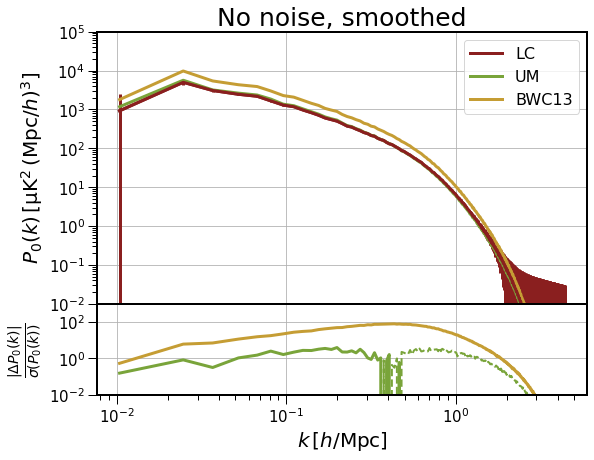

In [88]:
gs = gridspec.GridSpec(2, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0,height_ratios=[3,1])
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

ax.loglog(CO.k_Pk_poles, CO.Pk_0, label='LC')
ax.errorbar(CO.k_Pk_poles.value, CO.Pk_0.value,np.sqrt(CO.covmat_00.value),color=colors[0],alpha=1)
ax.loglog(CO_UM.k_Pk_poles, CO_UM.Pk_0, label='UM')
ax.loglog(CO_BWC.k_Pk_poles, CO_BWC.Pk_0, label='BWC13')

ax.set_ylabel(r'$P_0(k) \,[{\rm \mu K^2\, (Mpc/}h)^3] $',fontsize=20)
ax.set_xlabel(r'$k\,  [h/{\rm Mpc}]$',fontsize=20)
ax.grid()

ax.set_ylim(1e-2,1e5)

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)

ax.legend(fontsize=16)
ax.set_title('No noise, smoothed',fontsize=25)

ax = plt.subplot(gs[1,0])

ax.loglog(CO.k_Pk_poles, (CO.Pk_0-CO.Pk_0)/np.sqrt(CO.covmat_00), label='LC')
ax.loglog(CO_UM.k_Pk_poles, (CO_UM.Pk_0-CO.Pk_0)/np.sqrt(CO.covmat_00), label='UM')
ax.loglog(CO_BWC.k_Pk_poles, (CO_BWC.Pk_0-CO.Pk_0)/np.sqrt(CO.covmat_00), label='BWC13')

ax.loglog(CO_UM.k_Pk_poles, -(CO_UM.Pk_0-CO.Pk_0)/np.sqrt(CO.covmat_00), label='UM',ls='--',color=colors[1],lw=2)
ax.loglog(CO_BWC.k_Pk_poles, -(CO_BWC.Pk_0-CO.Pk_0)/np.sqrt(CO.covmat_00), label='BWC13',ls='--',color=colors[2],lw=2)

ax.set_ylabel(r'$\frac{\vert\Delta P_0(k)\vert}{\sigma(P_0(k))}$',fontsize=20)
ax.set_xlabel(r'$k\,  [h/{\rm Mpc}]$',fontsize=20)

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)

ax.set_ylim(1e-2,1000)
ax.grid()

plt.show()

In [57]:
CO.update(Tmax_VID = 100*u.uK)
CO_UM.update(Tmax_VID = 100*u.uK)
CO_BWC.update(Tmax_VID = 100*u.uK)

<ipython-input-60-e40ac008ad83>:23: RuntimeWarning: invalid value encountered in true_divide
  ax.loglog(CO.Ti, (CO.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='LC')
<ipython-input-60-e40ac008ad83>:24: RuntimeWarning: divide by zero encountered in true_divide
  ax.loglog(CO.Ti, (CO_UM.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='UM')
<ipython-input-60-e40ac008ad83>:24: RuntimeWarning: invalid value encountered in true_divide
  ax.loglog(CO.Ti, (CO_UM.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='UM')
<ipython-input-60-e40ac008ad83>:25: RuntimeWarning: divide by zero encountered in true_divide
  ax.loglog(CO.Ti, (CO_BWC.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='BWC')
<ipython-input-60-e40ac008ad83>:25: RuntimeWarning: invalid value encountered in true_divide
  ax.loglog(CO.Ti, (CO_BWC.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='BWC')
<ipython-input-60-e40ac008ad83>:27: RuntimeWarning: 

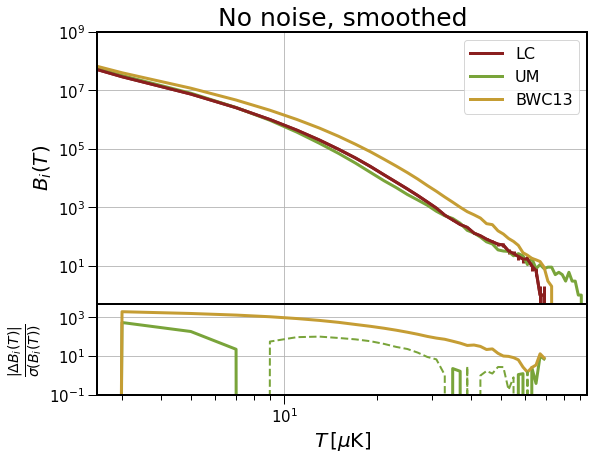

In [60]:
gs = gridspec.GridSpec(2, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0,height_ratios=[3,1])
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

ax.loglog(CO.Ti, CO.Bi_VID,label='LC')
ax.errorbar(CO.Ti.value, CO.Bi_VID, np.sqrt(np.diag(CO.Bi_VID_covariance)),color=colors[0],alpha=1)
ax.loglog(CO_UM.Ti, CO_UM.Bi_VID, label='UM')
ax.loglog(CO_BWC.Ti, CO_BWC.Bi_VID, label='BWC13')

ax.set_ylabel(r'$B_i(T) $',fontsize=20)
ax.set_xlabel(r'$T\,  [\mu{\rm K}]$',fontsize=20)
ax.grid()

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)
ax.set_ylim(0.5,1e9)
ax.set_xlim(2.5,95)
ax.legend(fontsize=16)
ax.set_title('No noise, smoothed',fontsize=25)
ax = plt.subplot(gs[1,0])

ax.loglog(CO.Ti, (CO.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='LC')
ax.loglog(CO.Ti, (CO_UM.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='UM')
ax.loglog(CO.Ti, (CO_BWC.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='BWC')

ax.loglog(CO.Ti, -(CO_UM.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='UM',ls='--',color=colors[1],lw=2)
ax.loglog(CO.Ti, -(CO_BWC.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='BWC13',ls='--',color=colors[2],lw=2)

ax.set_ylabel(r'$\frac{\vert\Delta B_i(T)\vert}{\sigma(B_i(T))}$',fontsize=20)
ax.set_xlabel(r'$T\,  [\mu{\rm K}]$',fontsize=20)

ax.set_ylim(0.1,5000)
ax.set_xlim(2.5,95)

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)
ax.grid()

plt.show()

## Noise, no smoothed

In [9]:
CO.update(Tsys = 10*u.K)
CO_UM.update(Tsys = 10*u.K)
CO_BWC.update(Tsys = 10*u.K)

In [13]:
CO.sigmaN

<Quantity 16.7600716 uK>

In [11]:
CO.Pk_2d
CO_UM.Pk_2d
CO_BWC.Pk_2d

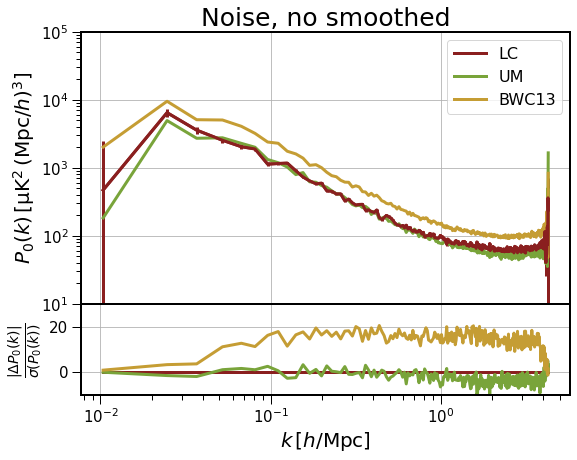

In [17]:
gs = gridspec.GridSpec(2, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0,height_ratios=[3,1])
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

ax.loglog(CO.k_Pk_poles, CO.Pk_0, label='LC')
ax.errorbar(CO.k_Pk_poles.value, CO.Pk_0.value,np.sqrt(CO.covmat_00.value),color=colors[0],alpha=1)
ax.loglog(CO_UM.k_Pk_poles, CO_UM.Pk_0, label='UM')
ax.loglog(CO_BWC.k_Pk_poles, CO_BWC.Pk_0, label='BWC13')

ax.set_ylabel(r'$P_0(k) \,[{\rm \mu K^2\, (Mpc/}h)^3] $',fontsize=20)
ax.set_xlabel(r'$k\,  [h/{\rm Mpc}]$',fontsize=20)
ax.grid()

ax.set_ylim(1e1,1e5)

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)

ax.legend(fontsize=16)
ax.set_title('Noise, no smoothed',fontsize=25)

ax = plt.subplot(gs[1,0])

ax.semilogx(CO.k_Pk_poles, (CO.Pk_0-CO.Pk_0)/np.sqrt(CO.covmat_00), label='LC')
ax.semilogx(CO_UM.k_Pk_poles, (CO_UM.Pk_0-CO.Pk_0)/np.sqrt(CO.covmat_00), label='UM')
ax.semilogx(CO_BWC.k_Pk_poles, (CO_BWC.Pk_0-CO.Pk_0)/np.sqrt(CO.covmat_00), label='BWC13')

ax.set_ylabel(r'$\frac{\vert\Delta P_0(k)\vert}{\sigma(P_0(k))}$',fontsize=20)
ax.set_xlabel(r'$k\,  [h/{\rm Mpc}]$',fontsize=20)

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)

ax.set_ylim(-10,30)
ax.grid()

plt.show()

In [19]:
CO.update(Tmax_VID = 2000*u.uK)
CO_UM.update(Tmax_VID = 2000*u.uK)
CO_BWC.update(Tmax_VID = 2000*u.uK)

<ipython-input-24-caf4a5b0173d>:23: RuntimeWarning: invalid value encountered in true_divide
  ax.semilogx(CO.Ti, (CO.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='LC')
<ipython-input-24-caf4a5b0173d>:24: RuntimeWarning: divide by zero encountered in true_divide
  ax.semilogx(CO.Ti, (CO_UM.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='UM')
<ipython-input-24-caf4a5b0173d>:24: RuntimeWarning: invalid value encountered in true_divide
  ax.semilogx(CO.Ti, (CO_UM.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='UM')
<ipython-input-24-caf4a5b0173d>:25: RuntimeWarning: divide by zero encountered in true_divide
  ax.semilogx(CO.Ti, (CO_BWC.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='BWC')
<ipython-input-24-caf4a5b0173d>:25: RuntimeWarning: invalid value encountered in true_divide
  ax.semilogx(CO.Ti, (CO_BWC.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='BWC')


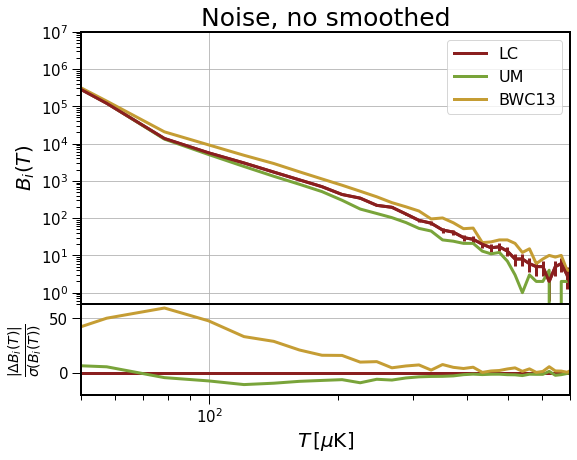

In [24]:
gs = gridspec.GridSpec(2, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0,height_ratios=[3,1])
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

ax.loglog(CO.Ti, CO.Bi_VID,label='LC')
ax.errorbar(CO.Ti.value, CO.Bi_VID, np.sqrt(np.diag(CO.Bi_VID_covariance)),color=colors[0],alpha=1)
ax.loglog(CO_UM.Ti, CO_UM.Bi_VID, label='UM')
ax.loglog(CO_BWC.Ti, CO_BWC.Bi_VID, label='BWC13')

ax.set_ylabel(r'$B_i(T) $',fontsize=20)
ax.set_xlabel(r'$T\,  [\mu{\rm K}]$',fontsize=20)
ax.grid()

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)
ax.set_ylim(0.5,1e7)
ax.set_xlim(50,700)
ax.legend(fontsize=16)
ax.set_title('Noise, no smoothed',fontsize=25)
ax = plt.subplot(gs[1,0])

ax.semilogx(CO.Ti, (CO.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='LC')
ax.semilogx(CO.Ti, (CO_UM.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='UM')
ax.semilogx(CO.Ti, (CO_BWC.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='BWC')

ax.set_ylabel(r'$\frac{\vert\Delta B_i(T)\vert}{\sigma(B_i(T))}$',fontsize=20)
ax.set_xlabel(r'$T\,  [\mu{\rm K}]$',fontsize=20)

#ax.set_ylim(0.1,5000)
ax.set_xlim(50,700)

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)
ax.grid()

plt.show()

## Noise, smoothed

In [25]:
CO.update(do_smooth=True)
CO_UM.update(do_smooth=True)
CO_BWC.update(do_smooth=True)

In [26]:
CO.Pk_2d
CO_UM.Pk_2d
CO_BWC.Pk_2d

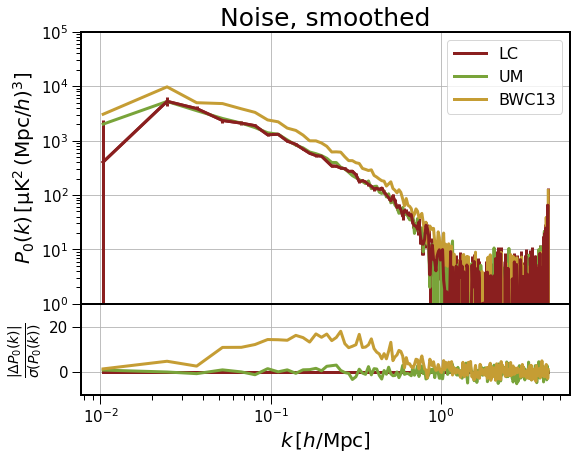

In [29]:
gs = gridspec.GridSpec(2, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0,height_ratios=[3,1])
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

ax.loglog(CO.k_Pk_poles, CO.Pk_0, label='LC')
ax.errorbar(CO.k_Pk_poles.value, CO.Pk_0.value,np.sqrt(CO.covmat_00.value),color=colors[0],alpha=1)
ax.loglog(CO_UM.k_Pk_poles, CO_UM.Pk_0, label='UM')
ax.loglog(CO_BWC.k_Pk_poles, CO_BWC.Pk_0, label='BWC13')

ax.set_ylabel(r'$P_0(k) \,[{\rm \mu K^2\, (Mpc/}h)^3] $',fontsize=20)
ax.set_xlabel(r'$k\,  [h/{\rm Mpc}]$',fontsize=20)
ax.grid()

ax.set_ylim(1e0,1e5)

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)

ax.legend(fontsize=16)
ax.set_title('Noise, smoothed',fontsize=25)

ax = plt.subplot(gs[1,0])

ax.semilogx(CO.k_Pk_poles, (CO.Pk_0-CO.Pk_0)/np.sqrt(CO.covmat_00), label='LC')
ax.semilogx(CO_UM.k_Pk_poles, (CO_UM.Pk_0-CO.Pk_0)/np.sqrt(CO.covmat_00), label='UM')
ax.semilogx(CO_BWC.k_Pk_poles, (CO_BWC.Pk_0-CO.Pk_0)/np.sqrt(CO.covmat_00), label='BWC13')

ax.set_ylabel(r'$\frac{\vert\Delta P_0(k)\vert}{\sigma(P_0(k))}$',fontsize=20)
ax.set_xlabel(r'$k\,  [h/{\rm Mpc}]$',fontsize=20)

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)

ax.set_ylim(-10,30)
ax.grid()

plt.show()

In [31]:
CO.update(Tmax_VID = 100*u.uK)
CO_UM.update(Tmax_VID = 100*u.uK)
CO_BWC.update(Tmax_VID = 100*u.uK)

<ipython-input-34-4aaf1aae4b96>:23: RuntimeWarning: invalid value encountered in true_divide
  ax.semilogx(CO.Ti, (CO.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='LC')
<ipython-input-34-4aaf1aae4b96>:24: RuntimeWarning: divide by zero encountered in true_divide
  ax.semilogx(CO.Ti, (CO_UM.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='UM')
<ipython-input-34-4aaf1aae4b96>:24: RuntimeWarning: invalid value encountered in true_divide
  ax.semilogx(CO.Ti, (CO_UM.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='UM')
<ipython-input-34-4aaf1aae4b96>:25: RuntimeWarning: divide by zero encountered in true_divide
  ax.semilogx(CO.Ti, (CO_BWC.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='BWC')
<ipython-input-34-4aaf1aae4b96>:25: RuntimeWarning: invalid value encountered in true_divide
  ax.semilogx(CO.Ti, (CO_BWC.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='BWC')


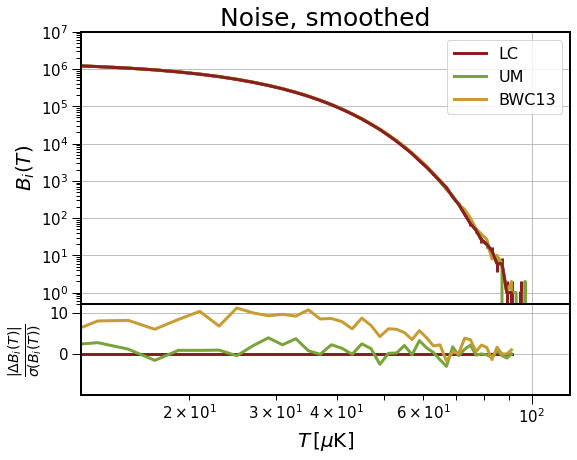

In [34]:
gs = gridspec.GridSpec(2, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0,height_ratios=[3,1])
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

ax.loglog(CO.Ti, CO.Bi_VID,label='LC')
ax.errorbar(CO.Ti.value, CO.Bi_VID, np.sqrt(np.diag(CO.Bi_VID_covariance)),color=colors[0],alpha=1)
ax.loglog(CO_UM.Ti, CO_UM.Bi_VID, label='UM')
ax.loglog(CO_BWC.Ti, CO_BWC.Bi_VID, label='BWC13')

ax.set_ylabel(r'$B_i(T) $',fontsize=20)
ax.set_xlabel(r'$T\,  [\mu{\rm K}]$',fontsize=20)
ax.grid()

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)
ax.set_ylim(0.5,1e7)
ax.set_xlim(12,120)
ax.legend(fontsize=16)
ax.set_title('Noise, smoothed',fontsize=25)
ax = plt.subplot(gs[1,0])

ax.semilogx(CO.Ti, (CO.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='LC')
ax.semilogx(CO.Ti, (CO_UM.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='UM')
ax.semilogx(CO.Ti, (CO_BWC.Bi_VID-CO.Bi_VID)/np.sqrt(np.diag(CO.Bi_VID_covariance)), label='BWC')

ax.set_ylabel(r'$\frac{\vert\Delta B_i(T)\vert}{\sigma(B_i(T))}$',fontsize=20)
ax.set_xlabel(r'$T\,  [\mu{\rm K}]$',fontsize=20)

#ax.set_ylim(0.1,5000)
ax.set_xlim(12,120)

ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)
ax.grid()

plt.show()

# Luminosity function

Using as first example here COSMOS+GOOD-N ("merged") from https://iopscience.iop.org/article/10.3847/1538-4357/aafc27/pdf which constraints the CO luminosity function at z=2.4

In [4]:
def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor='r',
                     edgecolor='None', alpha=0.5):

    # Loop over data points; create box from errors at each point
    errorboxes = [rect((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
                  for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T)]

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    artists = ax.add_collection(pc)
    ax.plot(0,0)

    return artists

In [6]:
#DATA 
logLCOdat = np.arange(9.5,11.01,0.1)
LCOwidth = np.ones((2,len(logLCOdat)))*0.25
logphi_max = np.array([-2.21,-2.69,-2.95,-3.12,-3.24,-3.32,-3.41,-3.37,-3.39,-3.45,-3.60,-3.70,-4.11,-4.25,-4.41,-4.45])
logphi_min = np.array([-4.04,-4.08,-4.14,-4.19,-4.23,-4.10,-4.07,-3.76,-3.69,-3.73,-3.98,-4.10,-4.79,-5.00,-5.44,-6.28])
logphidat = 0.5*(logphi_max+logphi_min)
logphiwidth = np.ones((2,len(logLCOdat)))*0.5*(logphi_max-logphi_min)


In [8]:
z = 2.4
logM=np.log10(np.logspace(10, 14, 100))
sfr_um = SFR_Mz_2dinterp(10**logM,z,'../SFR_tables/sfr_table_normalmean_UniverseMachine_medianFalse_clean_solMass.dat')
sfr_bwc = SFR_Mz_2dinterp(10**logM,z,'../SFR_tables/sfr_table_Behroozi.dat')          
popt_um, pcov = curve_fit(func, 10**logM[np.logical_and(np.log10(sfr_um)>-3 , logM>10.5)], np.log10(sfr_um)[np.logical_and(np.log10(sfr_um)>-3, logM>10.5)],
                         p0=[8,12.3,1.9,3,-1.4])
popt_bwc, pcov = curve_fit(func, 10**logM[np.log10(sfr_bwc)>-3], np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3],
                          p0=[8,12.3,1.9,3,-0.7])

print('Universe Machine SFR at z = ',z)
print('-------------------------------')
print('M0 = {:.2f}, Ma = {:.2f}, Mb = {:.2f}'.format(-6,popt_um[0],popt_um[1]))
print('a = {:.2f}, b = {:.2f}, c = {:.2f}'.format(popt_um[2],popt_um[3],popt_um[4]))
print('')
print('BWC13 SFR at z = ',z)
print('-------------------------------')
print('M0 = {:.2f}, Ma = {:.2f}, Mb = {:.2f}'.format(-6,popt_bwc[0],popt_bwc[1]))
print('a = {:.2f}, b = {:.2f}, c = {:.2f}'.format(popt_bwc[2],popt_bwc[3],popt_bwc[4]))
print('')



Universe Machine SFR at z =  2.4
-------------------------------
M0 = -6.00, Ma = 8.14, Mb = 12.38
a = 1.89, b = 6.78, c = -0.55

BWC13 SFR at z =  2.4
-------------------------------
M0 = -6.00, Ma = 8.20, Mb = 12.35
a = 1.93, b = 6.43, c = -0.33



<ipython-input-8-ca6349a8456e>:7: RuntimeWarning: divide by zero encountered in log10
  popt_bwc, pcov = curve_fit(func, 10**logM[np.log10(sfr_bwc)>-3], np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3],


<ipython-input-9-f10ca47e36f2>:11: RuntimeWarning: divide by zero encountered in log10
  ax.plot(logM[np.log10(sfr_bwc)>-3],np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3],c=colors[2],label='BWC13')


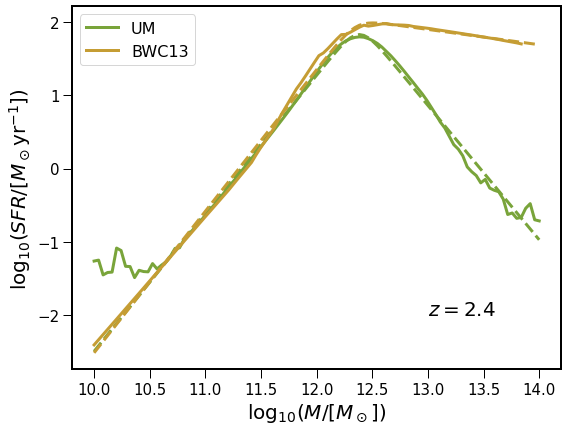

In [9]:
gs = gridspec.GridSpec(1, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0)
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

ax.plot(logM[np.log10(sfr_um)>-3],np.log10(sfr_um)[np.log10(sfr_um)>-3],c=colors[1],label='UM')
ax.plot(logM,func(10**logM,popt_um[0],popt_um[1],popt_um[2],
                            popt_um[3],popt_um[4]),c=colors[1],ls='--')


ax.plot(logM[np.log10(sfr_bwc)>-3],np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3],c=colors[2],label='BWC13')
ax.plot(logM,func(10**logM,popt_bwc[0],popt_bwc[1],popt_bwc[2],
                            popt_bwc[3],popt_bwc[4]),c=colors[2],ls='--')

ax.text(13,-2,r'$z = {}$'.format(z),fontsize=20)
ax.set_ylabel(r'$\log_{10} (SFR/ [M_\odot{\rm yr}^{-1}])$',fontsize=20)
ax.set_xlabel(r'$\log_{10} (M/ [M_\odot])$',fontsize=20)
ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)
ax.legend(fontsize=16)
plt.show()

In [18]:
Tsys = 0.
zmin_obs, zmax_obs =  2.032, 2.847
sigma_scatter=0.3
sig_SFR=0.5

model_um = dict(M0=1e-6, Ma=10**popt_um[0], Mb=10**popt_um[1], a=popt_um[2], b=popt_um[3], c=popt_um[4])
CO_UM = make_measurements(LC_params(True, 'Custom_SFR', model_um, Tsys,zmin_obs,zmax_obs,zmin=1.9,zmax=3.))

model_bwc =dict(M0=1e-6, Ma=10**popt_bwc[0], Mb=10**popt_bwc[1], a=popt_bwc[2], b=popt_bwc[3], c=popt_bwc[4])
CO_BWC = make_measurements(LC_params(True, 'Custom_SFR', model_bwc, Tsys,zmin_obs,zmax_obs,zmin=1.9,zmax=3.))

CO = make_measurements(LC_params(False, '', model_bwc, Tsys,zmin_obs,zmax_obs,zmin=1.9,zmax=3.))


/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_140.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_141.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_142.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_143.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_144.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_145.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_146.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_147.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_148.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_149.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_150.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_151.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_152.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_153.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_154.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_155.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_156.fi

/home/jlbernal/preLIMinary/source/line_models.py:34: RuntimeWarning: divide by zero encountered in log10
  log10_LCO = (np.log10(LIR) - beta)/alpha


In [27]:

logLCOcat = np.log10(CO.halos_in_survey['CO']['Lhalo'][CO.halos_in_survey['CO']['Lhalo'].value>0]/(3.2e-11*u.Lsun)/CO.line_nu0[CO.target_line].value**3)
logLCOcat_UM = np.log10(CO_UM.halos_in_survey['CO']['Lhalo'][CO_UM.halos_in_survey['CO']['Lhalo'].value>0]/(3.2e-11*u.Lsun)/CO.line_nu0[CO.target_line].value**3)
logLCOcat_BWC = np.log10(CO_BWC.halos_in_survey['CO']['Lhalo'][CO_BWC.halos_in_survey['CO']['Lhalo'].value>0]/(3.2e-11*u.Lsun)/CO.line_nu0[CO.target_line].value**3)

logLCO=np.linspace(np.min(logLCOcat), np.max(logLCOcat), 50)
logLCO_UM=np.linspace(np.min(logLCOcat_UM), np.max(logLCOcat_UM), 50)
logLCO_BWC=np.linspace(np.min(logLCOcat_BWC), np.max(logLCOcat_BWC), 50)



In [36]:
Nhalos, _=np.histogram(logLCOcat, bins=logLCO)
phi=Nhalos/np.diff(logLCO)[0]/((CO.Lbox[0]*CO.Lbox[1]*CO.Lbox[2]).to(u.Mpc**3))

Nhalos_UM, _=np.histogram(logLCOcat_UM, bins=logLCO_UM)
phi_UM=Nhalos_UM/np.diff(logLCO_UM)[0]/((CO_UM.Lbox[0]*CO_UM.Lbox[1]*CO_UM.Lbox[2]).to(u.Mpc**3))
                               
Nhalos_BWC, _=np.histogram(logLCOcat_BWC, bins=logLCO_BWC)
phi_BWC=Nhalos_BWC/np.diff(logLCO_BWC)[0]/((CO_BWC.Lbox[0]*CO_BWC.Lbox[1]*CO_BWC.Lbox[2]).to(u.Mpc**3))
                               
                               

<ipython-input-42-678490a1b475>:8: RuntimeWarning: divide by zero encountered in log10
  ax.plot(logLCO[:-1]+np.diff(logLCO)[0]/2,np.log10(phi.value),label='LC',color=colors[0])


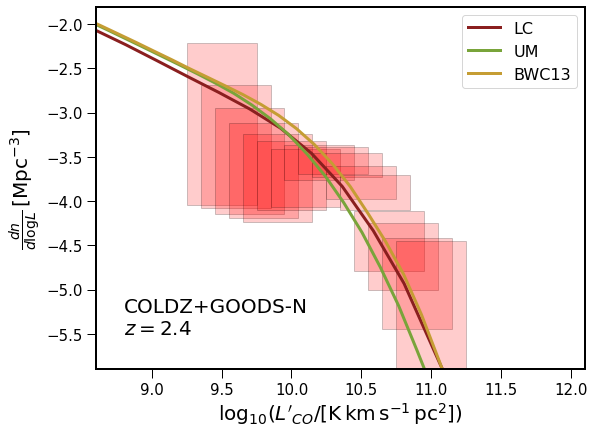

In [42]:
gs = gridspec.GridSpec(1, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0)
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

_ = make_error_boxes(ax,logLCOdat,logphidat,LCOwidth,logphiwidth,alpha=0.2,edgecolor='k')

ax.plot(logLCO[:-1]+np.diff(logLCO)[0]/2,np.log10(phi.value),label='LC',color=colors[0])
ax.plot(logLCO_UM[:-1]+np.diff(logLCO_UM)[0]/2,np.log10(phi_UM.value),label='UM',color=colors[1])
ax.plot(logLCO_BWC[:-1]+np.diff(logLCO_BWC)[0]/2,np.log10(phi_BWC.value),label='BWC13',color=colors[2])


plt.ylim(-5.9,-1.8)
plt.xlim(8.6,12.1)

ax.set_ylabel(r'$\frac{dn}{d\log L}\, [{\rm Mpc}^{-3}]$',fontsize=20)
ax.set_xlabel(r"$\log_{10} (L'_{CO}/ [{\rm K\, km\, s^{-1}\, pc^2}])$",fontsize=20)
ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)
ax.legend(fontsize=16)
ax.text(8.8,-5.5,'COLDZ+GOODS-N\n$z = 2.4$',fontsize=20)

plt.show()

# check new update

In [10]:
Tsys = 0.
zmin_obs, zmax_obs = 2.7,2.8
sigma_scatter=0.3
sig_SFR=0.5

model_um = dict(M0=1e-6, Ma=10**popt_um[0], Mb=10**popt_um[1], a=popt_um[2], b=popt_um[3], c=popt_um[4])
CO_UM = make_measurements(LC_params(True, 'Custom_SFR', model_um, Tsys,zmin_obs,zmax_obs,zmin=2.6,zmax=2.9,
                                   RAObs_edge = 0.5, DECObs_edge = 0.5))



In [16]:
CO_UM.update(zmin=2.55,SFR_pars=dict(M0=1e-4, Ma=10**popt_um[0], Mb=10**popt_um[1], a=popt_um[2], b=popt_um[3], c=popt_um[4]*10))

In [13]:
CO_UM.update(dk=0.2*u.Mpc**-1)

AttributeError: covmat_00

In [ ]:
CO.

In [17]:
np.mean(CO_UM.L_line_halo['CO'])

/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_164.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_165.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_166.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_167.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_168.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_169.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_170.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_171.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_172.fits


<Quantity 302393.30610515 solLum>

In [11]:
plt.loglog(CO_UM.k_Pk_poles,CO_UM.covmat_00**0.5)
plt.loglog(CO_UM.k_Pk_poles,CO_UM.Pk_0)


/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_166.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_167.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_168.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_169.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_170.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_171.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_172.fits
Note: redshifts have been re-sorted (earliest first)


ValueError: A value in x_new is below the interpolation range.

In [12]:
CO_UM.k_Pk_poles

<Quantity [0.        ,        nan,        nan,        nan,        nan,
           0.08596209,        nan,        nan, 0.12156973,        nan,
           0.14889231, 0.17192419, 0.1915888 , 0.19253271, 0.21056496,
                  nan, 0.24313947, 0.25788824, 0.27183679, 0.28510544,
           0.30335614, 0.31884506,        nan, 0.35077682, 0.36012156,
           0.37682192, 0.39171401, 0.40320205, 0.42112991, 0.4358214 ,
           0.44667406, 0.46500278, 0.47545339, 0.49566475, 0.50823255,
           0.52480149, 0.53612388, 0.55234016, 0.5680697 , 0.57952097,
           0.60078471, 0.61042516, 0.62780847, 0.64351761, 0.65776182,
           0.67341939, 0.68650575, 0.69887282, 0.71471339, 0.73297205,
           0.74254882, 0.75649527, 0.77512021, 0.78929177, 0.80422138,
           0.81582888, 0.83195736, 0.84957673, 0.86312876, 0.8792459 ,
           0.8928089 , 0.90530655, 0.92166079, 0.93492781, 0.9503573 ,
           0.96501571, 0.98047604, 0.99506791, 1.01060376, 1.02446612,
      

# Compare covariances (no noise no smoothed)

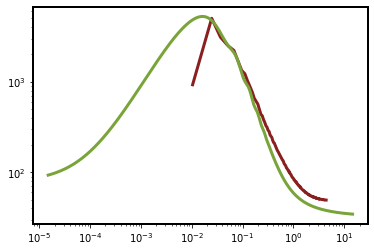

In [19]:
plt.loglog(CO.k_Pk_poles, CO.Pk_0, label='LC')
k,mu,pk2d = CO.Pk_2d_theo
pk0 = 0.5*np.trapz(pk2d,mu,axis=0)
plt.loglog(k,pk0)

In [19]:
plt.loglog(CO.k_Pk_poles,CO.covmat_00**0.5)
plt.loglog(CO.k_Pk_poles,CO.Pk_0)


TypeError: data type 'complex32' not understood

Note: redshifts have been re-sorted (earliest first)


(0.01, 10000.0)

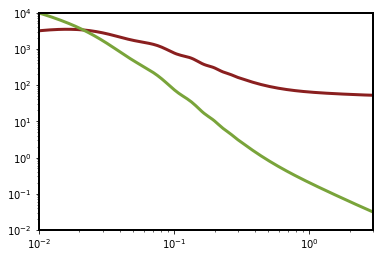

In [58]:
plt.loglog(M.k.to(M.Mpch**-1),M.Pk_0.to(M.Mpch**3*u.uK**2))
plt.loglog(M.k.to(M.Mpch**-1),(M.covmat_00**0.5).to(M.Mpch**3*u.uK**2))
plt.xlim(1e-2,3)
plt.ylim(1e-2,1e4)

In [68]:
print(len(M.Nmodes[0,(M.k.to(M.Mpch**-1).value<=3)&(M.k.to(M.Mpch**-1).value>=0.01)]),len(CO.Pk_2d.poles['modes']))

159 299


In [63]:
from astropy.io import fits


In [64]:
name = 'test'
hdu = fits.PrimaryHDU(CO.obs_map)
hdu.writeto(name)

In [78]:
from nbodykit.source.mesh import bigfile

In [85]:
from nbodykit.source.mesh.array import ArrayMesh

In [81]:
CO.obs_map.ravel

<bound method Field.ravel of RealField:array([[[0.04059691, 0.04633535, 0.04796079, ..., 0.01530917,
         0.02327018, 0.03225648],
        [0.04268923, 0.04858574, 0.05015019, ..., 0.01632138,
         0.0246383 , 0.03402142],
        [0.04277656, 0.04861728, 0.05015644, ..., 0.01673742,
         0.02489763, 0.03418214],
        ...,
        [0.03591412, 0.04276146, 0.04648489, ..., 0.01261341,
         0.0193743 , 0.02755378],
        [0.03536075, 0.04107574, 0.04340637, ..., 0.01295522,
         0.01977248, 0.02769441],
        [0.03761514, 0.04317027, 0.04497126, ..., 0.01403023,
         0.02138042, 0.0297476 ]],

       [[0.05230657, 0.06031833, 0.06310695, ..., 0.01923053,
         0.02943538, 0.0411594 ],
        [0.05475572, 0.06300883, 0.06578869, ..., 0.02037792,
         0.0309914 , 0.04319036],
        [0.05503563, 0.06323832, 0.06598623, ..., 0.02096049,
         0.03141641, 0.04352961],
        ...,
        [0.04853913, 0.05780597, 0.06281298, ..., 0.01701801,
       

In [80]:
import bigfile
import warnings
import json
from nbodykit.utils import JSONEncoder

with bigfile.FileMPI(self.pm.comm, output, create=True) as ff:
    data = numpy.empty(shape=field.size, dtype=field.dtype)
    field.ravel(out=data)
    with ff.create_from_array(dataset, data) as bb:
        if isinstance(field, RealField):
            bb.attrs['ndarray.shape'] = field.cshape
            bb.attrs['BoxSize'] = field.pm.BoxSize
            bb.attrs['Nmesh'] = field.pm.Nmesh
        elif isinstance(field, BaseComplexField):
            bb.attrs['ndarray.shape'] = field.cshape
            bb.attrs['BoxSize'] = field.pm.BoxSize
            bb.attrs['Nmesh'] = field.pm.Nmesh

        for key in field.attrs:
            # do not override the above values -- they are vectors (from pm)
            if key in bb.attrs: continue
            value = field.attrs[key]
            try:
                bb.attrs[key] = value
            except ValueError:
                try:
                    json_str = 'json://'+json.dumps(value, cls=JSONEncoder)
                    bb.attrs[key] = json_str
                except:
                    warnings.warn("attribute %s of type %s is unsupported and lost while saving MeshSource" % (key, type(value)))

In [82]:
hdul = fits.open('test')

In [107]:
bb = hdul[0].data

In [87]:
CO.Lbox

<Quantity [272.43413257, 649.42386287, 649.42386287] 1.47493 Mpc>

In [108]:
aa = ArrayMesh(bb.byteswap().newbyteorder(),BoxSize=CO.Lbox.value)

In [112]:
aa.field.r2c()

TransposedComplexField:array([[[ 4.33897316e-01-2.41792431e-09j,
         -1.38124474e-03+7.48551800e-04j,
         -4.50315326e-03-2.05444172e-03j, ...,
         -2.03353689e-09-2.90123814e-09j,
          3.02530362e-11+3.14749804e-09j,
          5.00261566e-09-3.50958176e-17j],
        [-4.20906208e-03-2.24042963e-03j,
          4.21269564e-04-5.11322403e-04j,
         -5.57075022e-03+2.41734809e-03j, ...,
         -1.25687863e-10+6.14458207e-11j,
          2.78946588e-10-3.04319347e-10j,
          1.04727317e-10+6.08011627e-11j],
        [-7.02594547e-03+2.93610338e-03j,
          1.10188611e-02-1.57412991e-03j,
          8.92645214e-04-1.61470950e-03j, ...,
          6.27715657e-11+1.53515492e-10j,
          1.49930263e-10+1.76303333e-10j,
         -2.41997793e-11-2.72288803e-10j],
        ...,
        [ 3.79971555e-03-3.71381757e-03j,
         -2.47267424e-03+4.73927567e-03j,
         -3.08735296e-03+1.66423991e-03j, ...,
          8.71006670e-11-3.23674421e-11j,
          9.83468

In [91]:
CO.Lbox.value

array([272.43413257, 649.42386287, 649.42386287])

In [113]:
hdul.close()

In [75]:
CO.obs_map.r2c()

TransposedComplexField:array([[[ 4.33897316e-01-2.41792431e-09j,
         -1.38124474e-03+7.48551800e-04j,
         -4.50315326e-03-2.05444172e-03j, ...,
         -2.03353689e-09-2.90123814e-09j,
          3.02530362e-11+3.14749804e-09j,
          5.00261566e-09-3.50958176e-17j],
        [-4.20906208e-03-2.24042963e-03j,
          4.21269564e-04-5.11322403e-04j,
         -5.57075022e-03+2.41734809e-03j, ...,
         -1.25687863e-10+6.14458207e-11j,
          2.78946588e-10-3.04319347e-10j,
          1.04727317e-10+6.08011627e-11j],
        [-7.02594547e-03+2.93610338e-03j,
          1.10188611e-02-1.57412991e-03j,
          8.92645214e-04-1.61470950e-03j, ...,
          6.27715657e-11+1.53515492e-10j,
          1.49930263e-10+1.76303333e-10j,
         -2.41997793e-11-2.72288803e-10j],
        ...,
        [ 3.79971555e-03-3.71381757e-03j,
         -2.47267424e-03+4.73927567e-03j,
         -3.08735296e-03+1.66423991e-03j, ...,
          8.71006670e-11-3.23674421e-11j,
          9.83468